In [159]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import numpy as np

In [160]:
class RNNScratch(d2l.HyperParameters, nn.Module):
    def __init__(self, num_inputs, num_hiddens, sigma  = 0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = nn.Parameter(
            torch.randn(num_inputs, num_hiddens)*sigma
        )
        self.W_hh = nn.Parameter(
            torch.randn(num_hiddens, num_hiddens) * sigma 
        )
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))
    
    def forward(self, inputs, state = None):
        if state is None:
            state = torch.zeros((inputs.shape[1], self.num_hiddens), 
                                device = inputs.device)
        else:
            state, = state
        
        outputs = []
        for X in inputs:
            state = torch.tanh(torch.matmul(X, self.W_xh) +
                               torch.matmul(state, self.W_hh) + self.b_h)
            outputs.append(state)
        return outputs, state

In [161]:
batch_size, num_inputs, num_hiddens, num_steps = 1024, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
X = torch.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X)

In [162]:
d2l.check_len(outputs, num_steps)
d2l.check_shape(outputs[0], (batch_size, num_hiddens))
d2l.check_shape(state, (batch_size, num_hiddens))

In [163]:
class RNNLMScratch(nn.Module, d2l.HyperParameters):
    def __init__(self, rnn, vocab_size, lr = 0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()
    
    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma
        )
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def loss(self, Y_hat, Y, averaged=True):
        Y_hat = d2l.reshape(Y_hat, (-1, Y_hat.shape[-1]))
        Y = d2l.reshape(Y, (-1,))
        return F.cross_entropy(
            Y_hat, Y, reduction='mean' if averaged else 'none')
    
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        return l

    def one_hot(self, X):
        return F.one_hot(X.T, self.vocab_size).type(torch.float32)
    
    def output_layer(self, rnn_outputs):
        outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
        return torch.stack(outputs, 1)
    
    def forward(self, X, state=None):
        embs = self.one_hot(X)
        rnn_outputs, _ = self.rnn(embs, state)
        return self.output_layer(rnn_outputs)
    
    def predict(self, prefix, num_preds, vocab, device=None):
        state, outputs = None, [vocab[prefix[0]]]
        for i in range(len(prefix) + num_preds - 1):
            X = torch.tensor([[outputs[-1]]], device=device)
            embs = self.one_hot(X)
            rnn_outputs, state = self.rnn(embs, state)
            if i < len(prefix) - 1:  # Warm-up period
                outputs.append(vocab[prefix[i + 1]])
            else:  # Predict num_preds steps
                Y = self.output_layer(rnn_outputs)
                outputs.append(int(Y.argmax(axis=2).reshape(1)))
        return ''.join([vocab.idx_to_token[i] for i in outputs])

In [164]:
model = RNNLMScratch(rnn, num_inputs)
outputs = model(torch.ones((batch_size, num_steps), dtype=torch.int64))
d2l.check_shape(outputs, (batch_size, num_steps, num_inputs))
# list(model.parameters())

In [165]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)

In [166]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# Model summary
model.to(DEVICE)
list(model.parameters())

[Parameter containing:
 tensor([[-1.8148e-02, -1.4736e-03, -4.5782e-03,  4.1235e-03, -2.8075e-03,
          -4.1574e-03,  8.2410e-03,  8.5909e-03, -1.7165e-02,  1.4106e-02,
           1.4340e-02, -1.9152e-03, -1.0887e-03, -8.9517e-03,  1.5592e-02,
          -1.2385e-02, -1.4960e-02,  6.3789e-04, -5.1916e-03, -4.6664e-04,
          -5.6364e-04, -6.6652e-04, -8.2285e-03,  1.0780e-03, -2.1496e-03,
           1.6464e-02,  2.3502e-02, -1.8453e-02],
         [ 6.3609e-03, -7.2537e-03,  5.4078e-04,  1.5462e-03, -1.5653e-02,
          -9.3609e-03,  7.5410e-03,  6.5399e-03, -4.2126e-03,  4.7036e-04,
          -4.1626e-03,  2.3808e-03, -1.3006e-03, -5.7005e-04,  4.8375e-04,
          -9.2830e-03, -1.0090e-02,  4.2756e-03, -1.0246e-02, -9.6221e-03,
          -4.1597e-04,  1.4415e-02,  4.0341e-03,  1.7207e-02,  1.0577e-03,
           9.0278e-03, -6.7085e-03, -1.9901e-03],
         [ 6.8656e-03,  1.6867e-02, -1.0766e-03,  2.6962e-03,  3.5231e-04,
          -6.7540e-03, -9.3744e-03, -1.4447e-03, -3.

In [167]:
model.predict('it has', 20, data.vocab, DEVICE)

'it hascynmohxe ae ae ae ae'

In [168]:
data = d2l.TimeMachine(batch_size, num_steps)

In [ ]:
# trainer = d2l.Trainer(max_epochs=500, gradient_clip_val=1, num_gpus=1)
# trainer.fit(model, data)
train_iter = data.get_dataloader(True)
val_iter = data.get_dataloader(False)

def prepare_batch(batch):
    if DEVICE == "cuda":
        batch = [x.to(DEVICE) for x in batch]
    return batch

def train(model : RNNLMScratch, data, max_epochs = 100):
    optim = torch.optim.SGD(model.parameters(), model.lr)
    animator = d2l.Animator(
        xlabel = "epoch", ylabel = "perplexity", legend = ["train", "valid"]
    )
    for epoch in range(max_epochs):
        model.train()
        train_ppl = []
        valid_ppl = []
        for batch in train_iter:
            loss = model.training_step(prepare_batch(batch))
            optim.zero_grad()
            loss.backward()
            d2l.grad_clipping(model, 1)
            optim.step()
            train_ppl.append(np.exp(loss.cpu().detach().numpy()))
        
        for batch in val_iter:
            with torch.no_grad():
                loss = model.validation_step(prepare_batch(batch))
                valid_ppl.append(np.exp(loss.cpu().detach().numpy()))
        animator.add([epoch + 1] * 2, [np.mean(train_ppl), np.mean(valid_ppl)])

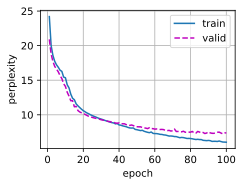

In [170]:

train(model, data)

In [171]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has of the the the the '